# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [9]:
import os 
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the.env file.")

print("API key loaded from.env file.")


API key loaded from.env file.


In [46]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [47]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(  model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY,)
llm.invoke(messages)

AIMessage(content='That\'s great you\'re interested in ocean mammals beyond whales!  There\'s a fascinating world of them to explore.  Here are some other groups you should learn about, categorized for easier understanding:\n\n**1. Seals, Sea Lions, and Walruses (Pinnipeds):**  These are all closely related, but have key differences:\n\n* **Seals (True Seals):** Lack external ear flaps, have smaller front flippers, and typically move on land by wriggling.  Examples include harbor seals, harp seals, and leopard seals.\n* **Sea Lions:** Have external ear flaps, larger front flippers, and can "walk" on land using their flippers. Examples include California sea lions and Steller sea lions.\n* **Walruses:**  Distinctive for their large tusks and thick blubber.  They are adapted for feeding on benthic (bottom-dwelling) invertebrates.\n\n**2. Sirenians (Manatees and Dugongs):**  These are gentle giants, completely aquatic mammals that graze on seagrass.\n\n* **Manatees:** Found in warmer, coa

We can run our chat model in a simple graph with `MessagesState`.


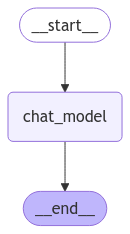

In [48]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great starting point! Whales are a fascinating group, but the ocean holds a wealth of other incredible mammals.  To suggest further research, let's categorize them:

**1.  Carnivora (Meat-Eaters):**

* **Seals:**  A diverse group including harbor seals, elephant seals (known for their massive size), harp seals (with their distinctive black and white coats), and many others.  Learn about their adaptations for swimming and hunting, their breeding habits, and the threats they face.
* **Sea Lions:**  Distinguished from seals by their external ear flaps and greater agility on land.  California sea lions are a

In [50]:
async for i in graph.astream_events({'messages': messages},version='v2'):
    print(i['data'])
    print("\n+++++++++++++++++")

{'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97')]}}

+++++++++++++++++
{'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97')]}}

+++++++++++++++++
{'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'),

In [51]:
async for i in graph.astream_events({'messages': messages}, version='v2'):
    if 'output' in i['data']:
        print(i['data']['output'])
        print("\n+++++++++++++++++")

{'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97')]}

+++++++++++++++++
{'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97')]}

+++++++++++++++++
{'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I kn

In [52]:
async for i in graph.astream_events({'messages': messages}, version='v2'):
    if 'output' in i['data'] and 'messages' in i['data']['output']:
        print(i['data']['output']['messages'])
        print("\n+++++++++++++++++")

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97')]

+++++++++++++++++
[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97')]

+++++++++++++++++
[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I

In [53]:
async for i in graph.astream_events({'messages': messages}, version='v2'):
    if 'output' in i['data'] and 'messages' in i['data']['output']: 
        message = i['data']['output']['messages']
        if isinstance(message, AIMessage):   
            print(message.content)  
            print("\n+++++++++++++++++")

That's great you're familiar with whales!  Beyond whales, the world of ocean mammals is incredibly diverse.  To suggest further research, let's break it down by group:

**1. Marine Mammals closely related to land mammals:**

* **Seals (Pinnipeds):**  This group includes three families:
    * **True seals (Phocidae):** Lack external ear flaps, have streamlined bodies for swimming, and are generally less agile on land. Examples include harbor seals, harp seals, and elephant seals.
    * **Eared seals (Otariidae):** Possess external ear flaps, are more agile on land, and use their foreflippers for propulsion in the water.  Examples include sea lions and fur seals.
    * **Walruses (Odobenidae):**  Easily recognizable by their tusks, they are adapted to cold arctic waters and feed on clams and other invertebrates.

* **Sea Otters (Mustelidae):**  These are the smallest marine mammals and are incredibly important for their role in maintaining kelp forests.  They're known for their use of to

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

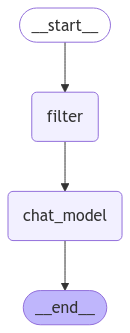

In [54]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import RemoveMessage

def filter_messages(state:MessagesState):
    delete_messages = [RemoveMessage(id=i.id) for i in state['messages'][:-2]]
    return {'messages':delete_messages}

def chat_model_node(state:MessagesState):
    return {"messages": llm.invoke(state["messages"])}
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

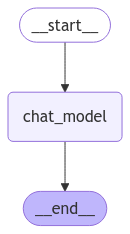

In [55]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]} #The function takes only the last message in the state["messages"] list (state["messages"][-1:]) and passes it to the llm.invoke method
 
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()
 
display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
 
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?

Knowing what you find interesting about whales will help me suggest similar topics.  

For example, if you like the migration aspect, you might be interested in:

* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.
* **Ocean currents and weather patterns:** These drive many migrations.
* **Navi

In [45]:
messagess = [1,2,3,4,5,6,7,8,9]
print(messagess[-1:])

[9]


## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

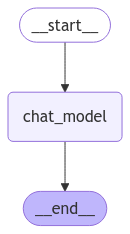

In [85]:
from langchain_core.messages import trim_messages

# Node
class ChatModel(MessagesState):
    pass
def chat_model_node(state: ChatModel):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY,model="gemini-1.5-flash"),
            allow_partial=False,
        )
    print(messages)
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(ChatModel)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [86]:
print(output['messages'])

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97'), AIMessage(content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many migrations.\n*

In [70]:
print(output['messages'][-1])

content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many migrations.\n* **Navigation and orientation in animals:** How do animals find their way over such vast distances?\n\nIf you are interested in their biology:\n\n* **Marine mammals in general:** Dolphins, porpoises, seals, sea lions, manatees.\n* **Deep-sea creatures:**  The bizarre adaptations of animals living in the deep ocean.\n* **Mammalian evolution:**  The story of how mammals

In [71]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"hi how are you", name="arman"))

In [87]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97'),
 AIMessage(content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many migrations.\

In [74]:
from langchain_core.messages import trim_messages
trim_messages(
            messages,
            max_tokens=400,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY,model="gemini-1.5-flash"),
            allow_partial=False
        )

[HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, name='arman', id='9512f2fb-9a5f-4187-808c-63f52938bcb3'),
 AIMessage(content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many migrations.\n* **Navigation and orientation in animals:** How do animals find their way over such vast distances?\n\nIf you are interested in their biology:\n\n* **Marine mammals in general:** Dolphins, porpoises, seals, sea lions,

In [75]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97'),
 AIMessage(content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many migrations.\

In [88]:

messages_out_trim = graph.invoke({'messages': messages})

[HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, name='arman', id='54b6284f-d89b-4df8-bae5-1c34455f7679')]


In [89]:
print(messages_out_trim)

{'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97'), AIMessage(content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many m

In [90]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97'),
 AIMessage(content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many migrations.\

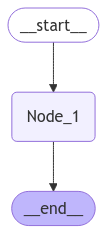

================================== Ai Message ==================================

AI stand for Artificial Inteligence
================================ Human Message =================================

Helle
================================== Ai Message ==================================

Hello there!


In [83]:
from langgraph.graph import StateGraph, START,END,MessagesState 
from langchain_core.messages import  AIMessage
 
def fun_llm_calls(msg:MessagesState):
    return {"messages":[llm.invoke(msg["messages"])]}
   

starting_graph:StateGraph = StateGraph(MessagesState)
starting_graph.add_node("Node_1",fun_llm_calls)
starting_graph.add_edge(START, 'Node_1')
starting_graph.add_edge('Node_1' ,END)
graph_compling = starting_graph.compile()
from IPython.display import display,Image
display(Image(graph_compling.get_graph().draw_mermaid_png()))

result = graph_compling.invoke({"messages":[AIMessage(content='AI stand for Artificial Inteligence'), HumanMessage(content="Helle")]})
for m in result["messages"]:
    m.pretty_print()

In [82]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='72d3e855-79a4-47ce-ace5-b3ce5087a953'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='fda2faf8-ad26-4c66-871f-34c85b7f1b97'),
 AIMessage(content='That depends on what interests you! To give you some suggestions, I need a little more information.  What aspects of whales fascinate you?  Is it their size, their migration patterns, their songs, their biology, their conservation status, or something else?\n\nKnowing what you find interesting about whales will help me suggest similar topics.  \n\nFor example, if you like the migration aspect, you might be interested in:\n\n* **Other migrating animals:**  Birds (especially shorebirds and waterfowl), Monarch butterflies, salmon, wildebeest.\n* **Ocean currents and weather patterns:** These drive many migrations.\